In [1]:
from __future__ import print_function, division
import torch
import matplotlib.pyplot as plt
import argparse,os
import pandas as pd
import cv2
import numpy as np
import random
import math
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from models.CDCNs import Conv2d_cd, CDCN, CDCNpp
from Load_CASIA_FASD_train import Spoofing_train, Normaliztion, ToTensor, RandomHorizontalFlip, Cutout, RandomErasing
from Load_CASIA_FASD_valtest import Spoofing_valtest, Normaliztion_valtest, ToTensor_valtest
# from Load_Single_Img import getTestImg
from Load_Single_Img_CASIA import getTestImg
import torch.nn.functional as F
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import copy
import pdb
from utils import AvgrageMeter, accuracy, performances
import torchvision.utils as vutils

# Dataset root
train_image_dir = '/mnt/hdd.user/datasets/CASIA-FASD/train_release_frame/'
test_image_dir = '/mnt/hdd.user/datasets/CASIA-FASD/test_release_frame/'
val_image_dir = test_image_dir

map_dir = '/mnt/hdd.user/datasets/CASIA-FASD/train_release_depth/'
test_map_dir = '/mnt/hdd.user/datasets/CASIA-FASD/test_release_depth/'
val_map_dir = test_map_dir
# 文件名1_2_11_3_frame140_depth.jpg

train_list = "./CASIA-FASD_videoname_len.txt"
# train_list = "/mnt/hdd.user/datasets/CASIA-FASD/Protocols/Train.txt"
test_list = "./CASIA-FASD_videoname_len_test.txt"
val_list = "./CASIA-FASD_videoname_len_val.txt"

device = torch.device("cuda:8")

device = torch.device("cpu")

In [2]:
# feature  -->   [ batch, channel, height, width ]
def FeatureMap2Heatmap( x, feature1, feature2, feature3, map_x):
    ## initial images 
    feature_first_frame = x[0,:,:,:].cpu()    ## the middle frame 
    ret_maps = []
    
    heatmap = torch.zeros(feature_first_frame.size(1), feature_first_frame.size(2))
    for i in range(feature_first_frame.size(0)):
        heatmap += torch.pow(feature_first_frame[i,:,:],2).view(feature_first_frame.size(1),feature_first_frame.size(2))

    heatmap = heatmap.data.numpy()
    ret_maps.append(heatmap)

    ## first feature
    feature_first_frame = feature1[0,:,:,:].cpu()    ## the middle frame 
    heatmap = torch.zeros(feature_first_frame.size(1), feature_first_frame.size(2))
    for i in range(feature_first_frame.size(0)):
        heatmap += torch.pow(feature_first_frame[i,:,:],2).view(feature_first_frame.size(1),feature_first_frame.size(2))

    heatmap = heatmap.data.numpy()
    ret_maps.append(heatmap)


    ## second feature
    feature_first_frame = feature2[0,:,:,:].cpu()    ## the middle frame 
    heatmap = torch.zeros(feature_first_frame.size(1), feature_first_frame.size(2))
    for i in range(feature_first_frame.size(0)):
        heatmap += torch.pow(feature_first_frame[i,:,:],2).view(feature_first_frame.size(1),feature_first_frame.size(2))

    heatmap = heatmap.data.numpy()
    ret_maps.append(heatmap)

    ## third feature
    feature_first_frame = feature3[0,:,:,:].cpu()    ## the middle frame 
    heatmap = torch.zeros(feature_first_frame.size(1), feature_first_frame.size(2))
    for i in range(feature_first_frame.size(0)):
        heatmap += torch.pow(feature_first_frame[i,:,:],2).view(feature_first_frame.size(1),feature_first_frame.size(2))

    heatmap = heatmap.data.numpy()
    ret_maps.append(heatmap)

    ## third feature
    heatmap2 = torch.pow(map_x[0,:,:],2)    ## the middle frame 

    heatmap2 = heatmap2.data.cpu().numpy()
    ret_maps.append(heatmap2)
    
    return {'img': ret_maps[0], 'attention1': ret_maps[1], 'attention2': ret_maps[2], 'attention3': ret_maps[3], 'depth_map': ret_maps[4]}

    
class Contrast_depth_loss(nn.Module):    # Pearson range [-1, 1] so if < 0, abs|loss| ; if >0, 1- loss
    def __init__(self):
        super(Contrast_depth_loss,self).__init__()
        return
    def forward(self, out, label): 
        '''
        compute contrast depth in both of (out, label),
        then get the loss of them
        tf.atrous_convd match tf-versions: 1.4
        '''
        # 根据out和label分别构造depth_conv，之后计算mseloss
        contrast_out = contrast_depth_conv(out)
        contrast_label = contrast_depth_conv(label)
        
        
        criterion_MSE = nn.MSELoss().to(device)
    
        loss = criterion_MSE(contrast_out, contrast_label)
        #loss = torch.pow(contrast_out - contrast_label, 2)
        #loss = torch.mean(loss)
    
        return loss
    
# model version
# input_image [batch, channel, height, width]
# output: heatmaps of the images and original predicted depth_map
def generatePredictedDepthMap(path, input_image):
    model_state_dict = torch.load(path, map_location={'cuda:7':'cpu'})
    model = CDCNpp(basic_conv=Conv2d_cd, theta=0.7)
    model.load_state_dict(model_state_dict)
    model.eval()
    
    
    with torch.no_grad():
        depth_map, embedding, attention1, attention2, attention3, img = model(input_image)
        heatmaps = FeatureMap2Heatmap(img, attention1, attention2, attention3, depth_map)
        
        return heatmaps, depth_map
    
# version + input[channel, height, width] + depth[height, width]
def showSingleResults(version, input_image, org_depth):
    heatmaps, map_x = generatePredictedDepthMap(f"./CDCNpp_CASIA_FASD/CDCNpp_CASIA_FASD_400.pkl", input_image.unsqueeze(0))
    
    fig = plt.figure(figsize = (15,15)) 

    ax = fig.add_subplot(331)
    ax.set_title('img')
    plt.imshow(np.transpose(vutils.make_grid(input_image, padding=2, normalize=True), (1,2,0)))
    plt.colorbar()

    ax = fig.add_subplot(332)
    ax.set_title('img_heatmap')
    plt.imshow(heatmaps['img'])
    plt.colorbar()

    ax = fig.add_subplot(334)
    ax.set_title('attention1')
    plt.imshow(heatmaps['attention1'])
    plt.colorbar()

    ax = fig.add_subplot(335)
    ax.set_title('attention2')
    plt.imshow(heatmaps['attention2'])
    plt.colorbar()

    ax = fig.add_subplot(336)
    ax.set_title('attention3')
    plt.imshow(heatmaps['attention3'])
    plt.colorbar()

    ax = fig.add_subplot(337)
    ax.set_title('org_depth_map')
    plt.imshow(org_depth, cmap='gray')
    plt.colorbar()

    ax = fig.add_subplot(338)
    ax.set_title('predicted_depth_heatmap')
    plt.imshow(heatmaps['depth_map'])
    plt.colorbar()

    ax = fig.add_subplot(339)
    ax.set_title('predicted_depth_map')
    plt.imshow(map_x[0], cmap='gray')
    plt.colorbar()

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument('--gpu', type=int, default=1, help='the gpu id used for predict')
parser.add_argument('--lr', type=float, default=0.0001, help='initial learning rate')  
parser.add_argument('--batchsize', type=int, default=7, help='initial batchsize')  
parser.add_argument('--step_size', type=int, default=500, help='how many epochs lr decays once')  # 500 
parser.add_argument('--gamma', type=float, default=0.5, help='gamma of optim.lr_scheduler.StepLR, decay of lr')
parser.add_argument('--echo_batches', type=int, default=50, help='how many batches display once')  # 50
parser.add_argument('--epochs', type=int, default=1300, help='total training epochs')
parser.add_argument('--log', type=str, default="CDCNpp_P1", help='log and save model name')
parser.add_argument('--finetune', action='store_true', default=False, help='whether finetune other models')

args = parser.parse_args(args=[])
print(args)

epsilon = 1e-2

Namespace(batchsize=7, echo_batches=50, epochs=1300, finetune=False, gamma=0.5, gpu=1, log='CDCNpp_P1', lr=0.0001, step_size=500)


In [4]:
test_real_img, test_real_depth = getTestImg(val_image_dir, val_map_dir, "0_0_12_1", 1)
test_real_img, test_real_depth = test_real_img.to(device), test_real_depth.to(device)
test_fake_img, test_fake_depth = getTestImg(val_image_dir, val_map_dir, "0_0_12_3", -1)
test_fake_img, test_fake_depth = test_fake_img.to(device), test_fake_depth.to(device)

/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


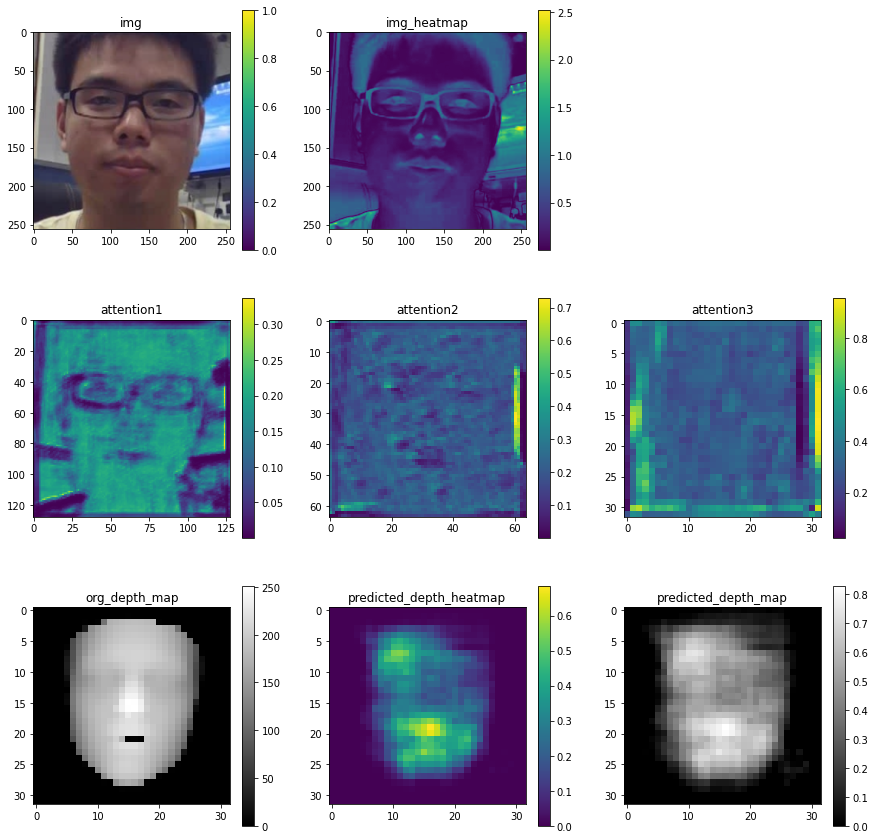

In [5]:
showSingleResults(451, test_real_img, test_real_depth)

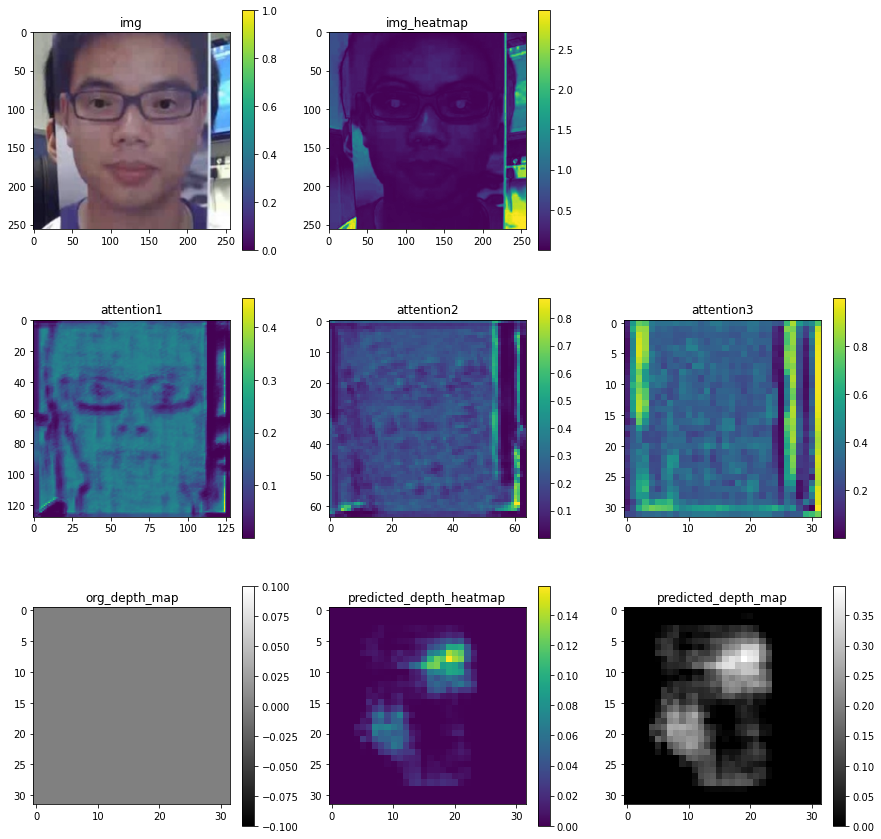

In [6]:
showSingleResults(451, test_fake_img, test_fake_depth)